In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torchvision
import captum
import captum.optim as optimviz

In [3]:
# get alexnet
from alexnet import model as alexnet

print(alexnet)

Using cache found in /home/kevin/.cache/torch/hub/pytorch_vision_v0.9.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [7]:
# Normal image optimization with captum appears to work
target = alexnet.features[8]
channel = 0

image = optimviz.images.NaturalImage((224, 224)).to("cuda")
loss_fn = optimviz.loss.ChannelActivation(target, channel)
transforms = torch.nn.Sequential(
    torch.nn.ReflectionPad2d(4),
    optimviz.transforms.RandomSpatialJitter(8),
    optimviz.transforms.RandomScale(scale=(1, 0.975, 1.025, 0.95, 1.05)),
    torchvision.transforms.RandomRotation(degrees=(-5, 5)),
    optimviz.transforms.RandomSpatialJitter(2),
)
obj = optimviz.InputOptimization(
    alexnet, input_param=image, loss_function=loss_fn)
history = obj.optimize(optimviz.optimization.n_steps(128, True))

  0%|          | 0/128 [00:00<?, ? step/s]

/home/kevin/.local/share/virtualenvs/231nFinalProject-K6JlCK0i/lib/python3.8/site-packages/torch/tensor.py:758: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:934.)
  return super(Tensor, self).refine_names(names)


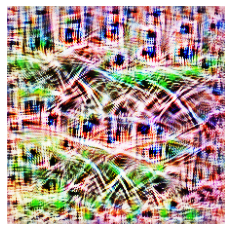

In [8]:
image().show()

In [13]:
from prior_optimization import create_optimized_image, display_optimized_image

biggan_input, loss_history = create_optimized_image(target=alexnet.features[8], channel=100, n_steps=256)
display_optimized_image(biggan_input)

  0%|          | 0/256 [00:00<?, ? step/s]

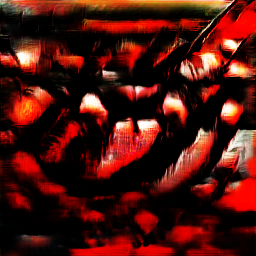

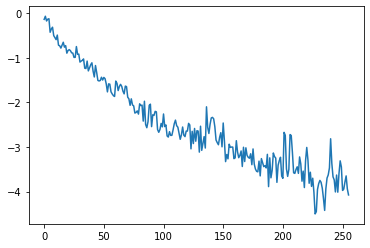

In [14]:
import matplotlib.pyplot as plt

plt.plot(loss_history.cpu().detach().numpy())